# Punto 1 Taller 1 (Juan Pablo Muñoz Zapata y Sebastián Sanchez Orrego)
Los bancos comerciales tradicionales no solían basarse en modelos estadísticos para decidir 
si debían emitirse préstamos personales, aunque esto está cambiando rápidamente en la 
actualidad. 

Usted es un analista que trabaja en un banco comercial moderno y le han 
solicitado construir modelos para calificar a un cliente en torno al riesgo posible de impago.

Va a encontrar un conjunto de datos llamado modern_bank.csv donde encuentra diferentes 
variables que describen a los prestatarios y al préstamo. 

Para este conjunto de datos

a. Identifique una variable estrechamente relacionada con la calificación de riesgo del 
cliente y a partir de esta construya un modelo de regresión logística que permita 
determinar dicha probabilidad.

b. Utilice todas las variables y construya un modelo de regresión logística multivariada que permita predecir la calificación de riesgo del cliente.

c. Utilice todas las variables necesarias y construya un modelo de máquina de soporte 
vectorial que permita predecir la probabilidad de riesgo del cliente.

d. Implemente un modelo de redes neuronales tipo perceptrón multicapa que le 
permita obtener la probabilidad de riesgo del cliente.

e. ¿cuál modelo genera un mejor desempeño? Explique.


In [ ]:
# LIBRERÍAS A UTILIZAR
# Advertencias
import warnings
warnings.filterwarnings('ignore')
# Tratamiento de datos
import pandas as pd
import numpy as np
# Gráficos
import matplotlib.pyplot as plt
import seaborn as sb
# Preparación de datos
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn import set_config
# Modelado
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
# Evaluación
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
# Montando el drive para acceder a los datos desde la nube
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Exploración y preparación de datos

## Cargar datos

In [ ]:
# Leyendo el csv y mostrando sus 5 primeros elementos
data = pd.read_csv('/content/drive/MyDrive/Análisis de Decisiones/modern_bank.csv')
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


## Exploración de datos

In [ ]:
# EXPLORACIÓN DE DATOS
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [ ]:
# IMPUTAR DATOS NULOS A person_emp_length, loan_int_rate
meanPersonEmpLength = data['person_emp_length'].mean()
meanLoanIntRate = data['loan_int_rate'].mean()
print(f'person_emp_length mean: {meanPersonEmpLength}')
print(f'loan_int_rate mean: {meanLoanIntRate}')

person_emp_length mean: 4.789686296787225
loan_int_rate mean: 11.011694892245036


In [ ]:
data['person_emp_length'].fillna(meanPersonEmpLength, inplace = True)
data['loan_int_rate'].fillna(meanLoanIntRate, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           32581 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               32581 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [ ]:
# EXPLORACIÓN ESTADÍSTICA DE DATOS
data.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,32581.000000,32581.000000,32581.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.085333,6322.086646,3.081605,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,8.490000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,11.011695,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.110000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [ ]:
data.describe(include = 'object')

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
count,32581,32581,32581,32581
unique,4,6,7,2
top,RENT,EDUCATION,A,N
freq,16446,6453,10777,26836


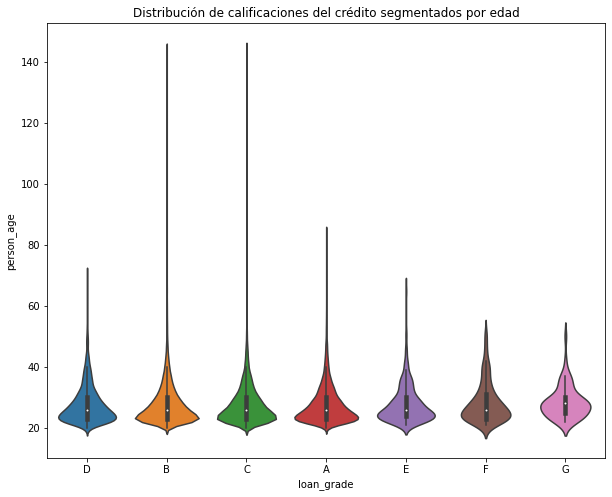

In [ ]:
# Gráfico de violin
fig, ax = plt.subplots(figsize = (10,8))
sb.violinplot(x = data['loan_grade'], y = data['person_age'], data = data, ax = ax)
ax.set_title('Distribución de calificaciones del crédito segmentados por edad')
plt.show()

In [ ]:
# Borrando datos atipicos en la variable person_age
data.loc[data['person_age'] > 100]['person_age'].value_counts()

144    3
123    2
Name: person_age, dtype: int64

In [ ]:
data.drop(data[data['person_age'] >= 100].index, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32576 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32576 non-null  int64  
 1   person_income               32576 non-null  int64  
 2   person_home_ownership       32576 non-null  object 
 3   person_emp_length           32576 non-null  float64
 4   loan_intent                 32576 non-null  object 
 5   loan_grade                  32576 non-null  object 
 6   loan_amnt                   32576 non-null  int64  
 7   loan_int_rate               32576 non-null  float64
 8   loan_status                 32576 non-null  int64  
 9   loan_percent_income         32576 non-null  float64
 10  cb_person_default_on_file   32576 non-null  object 
 11  cb_person_cred_hist_length  32576 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.2+ MB


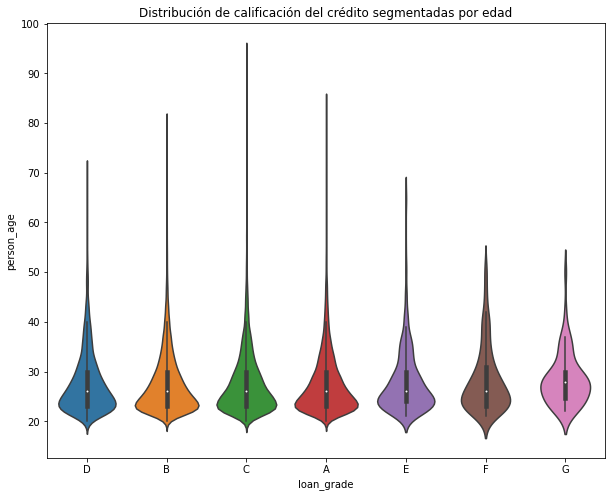

In [ ]:
# Gráfico de violin actualizado
fig, ax = plt.subplots(figsize = (10,8))
sb.violinplot(x = data['loan_grade'], y = data['person_age'], data = data, ax = ax)
ax.set_title('Distribución de calificación del crédito segmentadas por edad')
plt.show()

In [ ]:
#sb.pairplot(data = data, vars = ['person_age', 'person_income', 'loan_status' ], hue = 'loan_grade', kind = 'scatter')
#plt.show()

## Preparación de datos

In [ ]:
numCols = data.select_dtypes(include = ['float64', 'int64']).columns.to_list()
matCols = data[['person_home_ownership','loan_intent','cb_person_default_on_file']].columns.to_list()
ordCols =data[['loan_grade']].columns.tolist()

In [ ]:
numTransformer = Pipeline(steps = [('scaler',  MinMaxScaler())])
matTransformer = Pipeline(steps = [('onehot',  OneHotEncoder(handle_unknown = 'ignore'))])
ordTransformer = Pipeline(steps = [('ordinal', OrdinalEncoder(handle_unknown = 'error'))])

In [ ]:
preproccesor = ColumnTransformer(transformers = [
    ('numeric', numTransformer, numCols),
    ('catOHE', matTransformer, matCols),
    ('CatOrd', ordTransformer, ordCols)
], remainder = 'passthrough')

set_config(display = 'diagram')
preproccesor

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['person_age', 'person_income',
                                  'person_emp_length', 'loan_amnt',
                                  'loan_int_rate', 'loan_status',
                                  'loan_percent_income',
                                  'cb_person_cred_hist_length']),
                                ('catOHE',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['person_home_ownership', 'loan_intent',
                                  'cb_person_default_on_file']),
                                ('CatOrd',
                                 Pipeline(steps=[('ordinal',
                                                  OrdinalEncoder())]),
                                 ['loan_grade'])])

In [ ]:
dataPre = preproccesor.fit_transform(data)
dataPre

array([[2.70270270e-02, 2.70166187e-02, 1.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 3.00000000e+00],
       [1.35135135e-02, 2.75078299e-03, 4.06504065e-02, ...,
        1.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [6.75675676e-02, 2.75078299e-03, 8.13008130e-03, ...,
        1.00000000e+00, 0.00000000e+00, 2.00000000e+00],
       ...,
       [6.08108108e-01, 3.53672099e-02, 2.43902439e-02, ...,
        1.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [4.86486486e-01, 7.17168423e-02, 4.06504065e-02, ...,
        1.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [6.21621622e-01, 1.86660274e-02, 1.62601626e-02, ...,
        1.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [ ]:
dataPre.shape

(32576, 21)

In [ ]:
codCat = preproccesor.named_transformers_['catOHE']['onehot'].get_feature_names_out(matCols)
codCat

array(['person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER',
       'person_home_ownership_OWN', 'person_home_ownership_RENT',
       'loan_intent_DEBTCONSOLIDATION', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE',
       'cb_person_default_on_file_N', 'cb_person_default_on_file_Y'],
      dtype=object)

In [ ]:
labels = np.concatenate([numCols, codCat, ordCols])

In [ ]:
len(labels)

21

In [ ]:
dataPro = pd.DataFrame(dataPre, columns = labels)
dataPro.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_N,cb_person_default_on_file_Y,loan_grade
0,0.027027,0.027017,1.000000,1.000000,0.595506,1.0,0.710843,0.035714,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0
1,0.013514,0.002751,0.040650,0.014493,0.321348,0.0,0.120482,0.000000,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.067568,0.002751,0.008130,0.144928,0.418539,1.0,0.686747,0.035714,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0
3,0.040541,0.030209,0.032520,1.000000,0.551124,1.0,0.638554,0.000000,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0
4,0.054054,0.024757,0.065041,1.000000,0.497191,1.0,0.662651,0.071429,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0


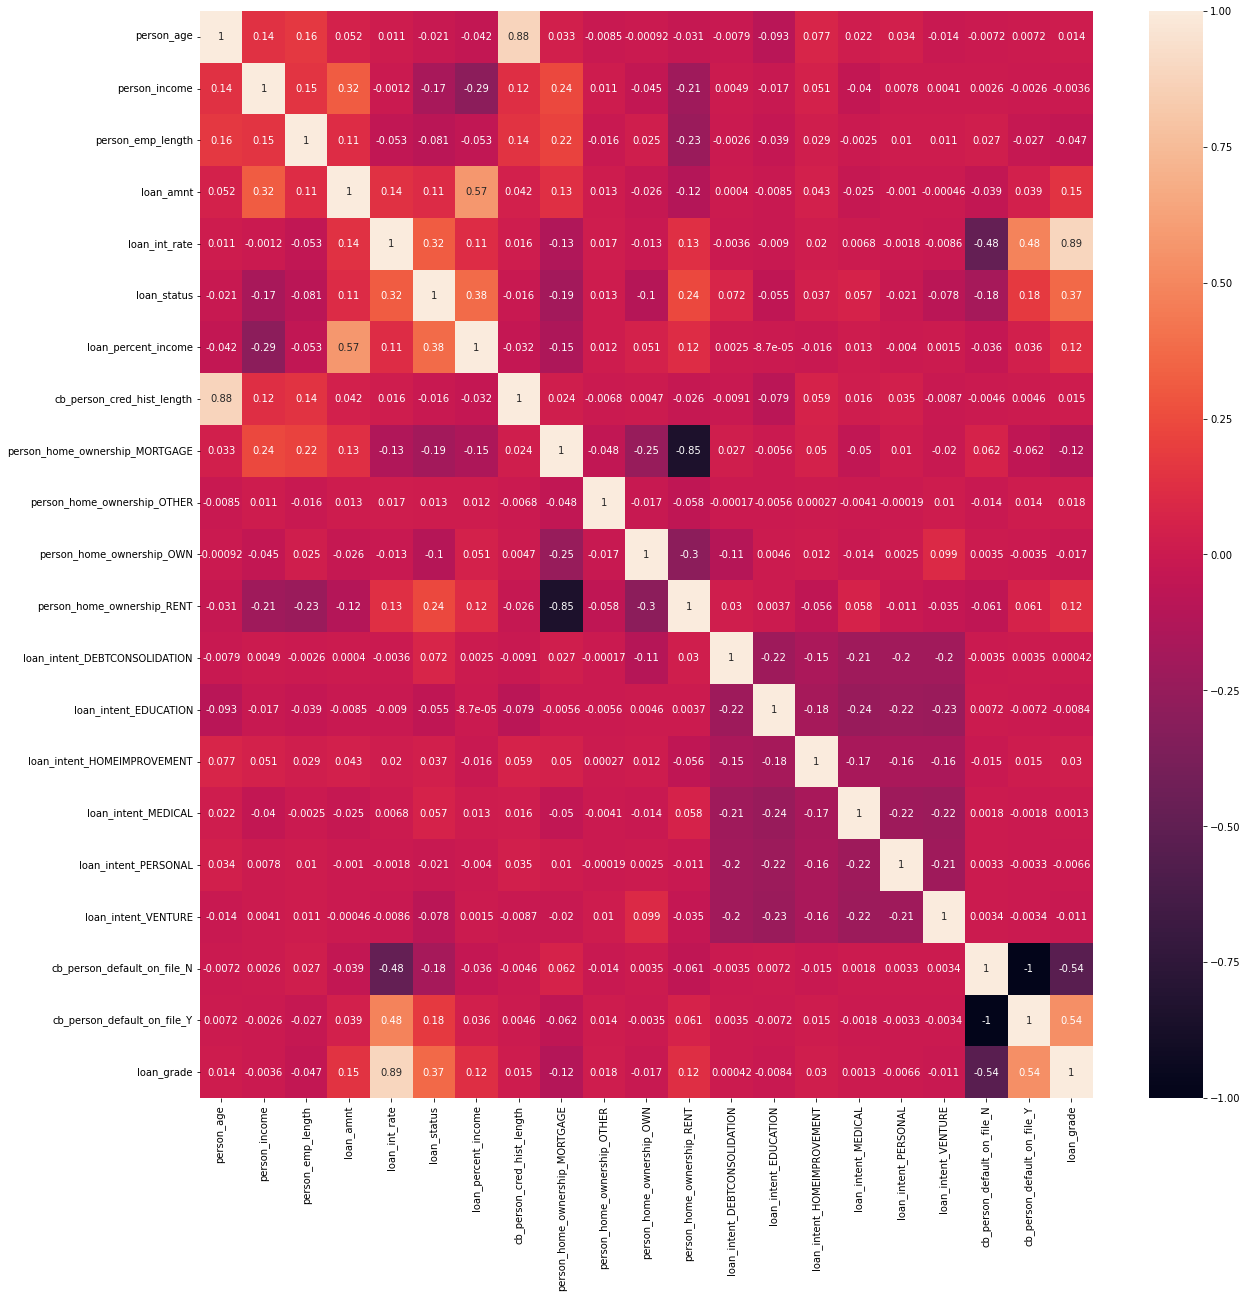

In [ ]:
plt.figure(figsize=(20,20))
sb.heatmap(dataPro.corr(), annot=True)
plt.show()

In [ ]:
X = dataPro.drop('loan_grade', axis = 1)
y = dataPro[['loan_grade']]

# Modelado

## A. Teniendo en cuenta solo la variable más relacionada

Entre todas las variables, la que está mas relacionada con loan_grade es loan_int_rate (Calificación del credito, tasa de interés del crédito)

Esto tiene mucho sentido ya que por lo general, la tasa de interés del crédito se basa en el riesgo de la persona.

In [ ]:
XMasValioso = dataPro[['loan_int_rate']]

In [ ]:
XTrain, XTest, yTrain, yTest = train_test_split(XMasValioso, y, train_size = 0.75, random_state = 123)

In [ ]:
XTrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24432 entries, 22463 to 19966
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   loan_int_rate  24432 non-null  float64
dtypes: float64(1)
memory usage: 381.8 KB


In [ ]:
modelLR = LogisticRegression()
modelLR.fit(XTrain, yTrain)

LogisticRegression()

In [ ]:
print('beta_0: ', modelLR.intercept_)
print('beta_1: ', list(zip(XMasValioso.columns, modelLR.coef_.flatten())))


beta_0:  [15.38742486  9.76366734  2.17701213 -3.23365071 -7.85252919 -9.08207011
 -7.15985432]
beta_1:  [('loan_int_rate', -41.691315805330674)]


In [ ]:
trainPred = modelLR.predict(XTrain)
trainAccuracy = accuracy_score(yTrain, trainPred)
print(f'El desempeño en entrenamiento es {round(trainAccuracy, 3)*100} %')

testPred = modelLR.predict(XTest)
testAcurracy = accuracy_score(yTest, testPred)
print(f'El desempeño en prueba es {round(testAcurracy,3)*100} %')

El desempeño en entrenamiento es 80.0 %
El desempeño en prueba es 80.0 %


El desempeño en entrenamiento y en prueba es similar y de un 80%, por lo que se puede decir que el modelo está ajustado. La predicción se encuentra sesgada por la cantidad de datos en cada una de las clases de la variable de salida

<AxesSubplot:>

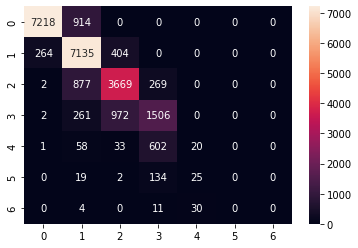

In [ ]:
matrizEntrenamiento = confusion_matrix(yTrain, trainPred)
sb.heatmap(matrizEntrenamiento, annot=True, fmt='d')

<AxesSubplot:>

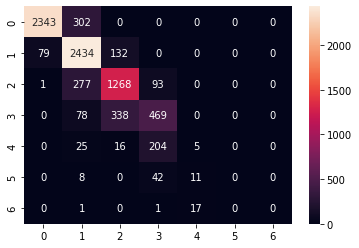

In [ ]:
matrizPrueba = confusion_matrix(yTest, testPred)
sb.heatmap(matrizPrueba, annot=True, fmt='d')

## B. Teniendo en cuenta todas las variables

In [ ]:
XTrain, XTest, yTrain, yTest = train_test_split(X, y, train_size = 0.75, random_state = 123)
modelLR2 = LogisticRegression()
modelLR2.fit(XTrain, yTrain)

LogisticRegression()

In [ ]:
print('beta_0: ', modelLR2.intercept_)
print('beta_1: ', list(zip(X.columns, modelLR2.coef_.flatten())))

beta_0:  [ 7.12065331  2.89749504  3.05022858 -0.67373025 -3.72810142 -4.81345979
 -3.85308547]
beta_1:  [('person_age', -0.34628479125108447), ('person_income', 0.5648645596146086), ('person_emp_length', -0.047519825314264574), ('loan_amnt', -1.853871850485177), ('loan_int_rate', -40.13571337199984), ('loan_status', -1.6756355752850411), ('loan_percent_income', 0.7783623692240328), ('cb_person_cred_hist_length', 0.0074526213351763255), ('person_home_ownership_MORTGAGE', 1.2178709120169602), ('person_home_ownership_OTHER', 0.9313312719275785), ('person_home_ownership_OWN', 0.9761657728518601), ('person_home_ownership_RENT', 1.1701488427661064), ('loan_intent_DEBTCONSOLIDATION', 0.9115556761286833), ('loan_intent_EDUCATION', 0.612584596536171), ('loan_intent_HOMEIMPROVEMENT', 0.48838613307366446), ('loan_intent_MEDICAL', 0.9042238402993977), ('loan_intent_PERSONAL', 0.6925111425136327), ('loan_intent_VENTURE', 0.6862554110109828), ('cb_person_default_on_file_N', 7.149982652774531), ('cb

In [ ]:
trainPred = modelLR2.predict(XTrain)
trainAccuracyAllVarsLR = accuracy_score(yTrain, trainPred)
print(f'El desempeño en entrenamiento es {round(trainAccuracyAllVarsLR, 3)*100} %')

El desempeño en entrenamiento es 81.5 %


In [ ]:
testPred = modelLR2.predict(XTest)
testAcurracy = accuracy_score(yTest, testPred)
print(f'El desempeño en prueba es {round(testAcurracy,3)*100} %')

El desempeño en prueba es 81.6 %


El desempeño en entrenamiento y en prueba es similar y de más de un 80%, por lo que se puede decir que el modelo está ajustado.

<AxesSubplot:>

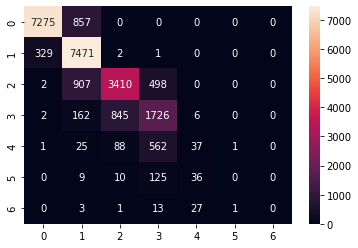

In [ ]:
matrizEntrenamiento = confusion_matrix(yTrain, trainPred)
sb.heatmap(matrizEntrenamiento, annot=True, fmt='d')

<AxesSubplot:>

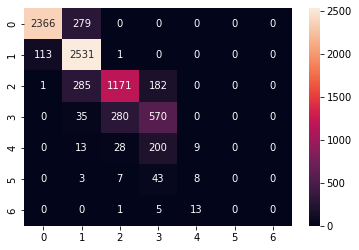

In [ ]:
matrizPrueba = confusion_matrix(yTest, testPred)
sb.heatmap(matrizPrueba, annot=True, fmt='d')

## Removiendo variables innecesarias

Las variables a remover son: 
- Edad: Ya que tiene un coeficiente de correlación de 0.88 con el historial crediticio, entonces nos aportan casi la misma información. En este contexto del problema es más importante analizar el historial crediticio.
- Marción de mercadeo (N): Se deja la marcación de mercadeo (Y) ya que tienen un coeficiente de correlación de -1, esto quiere decir que son excluyentes, nos aportan la misma información de manera inversa.
- Tipo de vivienda arrendada: Ya que tiene un coeficiente de correlación con el tipo de vivienda en hipoteca de -0.85, esto quiere decir que no están aportando información adicional entre las dos.

La tasa de interés no se borra ya que está estrechamente relacionada con la variable de salida, es la que nos aporta más información.



In [ ]:
dataPro.drop(['person_age','cb_person_default_on_file_N','person_home_ownership_RENT'], axis = 1, inplace=True)
X = dataPro

In [ ]:
XTrain, XTest, yTrain, yTest = train_test_split(X, y, train_size = 0.7, random_state = 456)

XTrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22803 entries, 12259 to 30619
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_income                   22803 non-null  float64
 1   person_emp_length               22803 non-null  float64
 2   loan_amnt                       22803 non-null  float64
 3   loan_int_rate                   22803 non-null  float64
 4   loan_status                     22803 non-null  float64
 5   loan_percent_income             22803 non-null  float64
 6   cb_person_cred_hist_length      22803 non-null  float64
 7   person_home_ownership_MORTGAGE  22803 non-null  float64
 8   person_home_ownership_OTHER     22803 non-null  float64
 9   person_home_ownership_OWN       22803 non-null  float64
 10  loan_intent_DEBTCONSOLIDATION   22803 non-null  float64
 11  loan_intent_EDUCATION           22803 non-null  float64
 12  loan_intent_HOMEIMPROVEMENT 

## C. SVC

In [ ]:
modelSVC = SVC()
modelSVC.fit(XTrain, yTrain)

trainPred = modelSVC.predict(XTrain)
trainAccuracyImpVarsSVC = accuracy_score(yTrain, trainPred)
print(f'El desempeño en entrenamiento es {trainAccuracyImpVarsSVC} %')

testPred = modelSVC.predict(XTest)
testAcurracy = accuracy_score(yTest, testPred)
print(f'El desempeño en prueba es {testAcurracy} %')

El desempeño en entrenamiento es 1.0 %
El desempeño en prueba es 1.0 %


<AxesSubplot:>

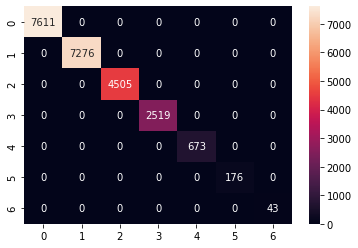

In [ ]:
matrizEntrenamiento = confusion_matrix(yTrain, trainPred)
sb.heatmap(matrizEntrenamiento, annot=True, fmt='d')

<AxesSubplot:>

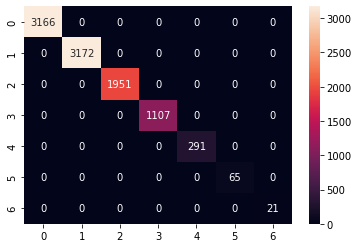

In [ ]:
matrizPrueba = confusion_matrix(yTest, testPred)
sb.heatmap(matrizPrueba, annot=True, fmt='d')

Aun si da 100% con los datos que tenemos, no se asegura que con datos nuevos siempre se de un buen resultado.

## D. MLP

In [ ]:
#Red Neuronal
model2 = MLPClassifier(hidden_layer_sizes=(10,10,5),learning_rate_init = 0.001)
model2.fit(XTrain, yTrain)


#Evaluacion
predMLPTrain = model2.predict(XTrain)
predMLPTest = model2.predict(XTest)
accuracyMLPTrain = accuracy_score(yTrain, predMLPTrain)
accuracyMLPTest = accuracy_score(yTest, predMLPTest)
print(f'Train acurracy: {accuracyMLPTrain} %')
print(f'Test acurracy: {accuracyMLPTest} %')

Train acurracy: 1.0 %
Test acurracy: 1.0 %


<AxesSubplot:>

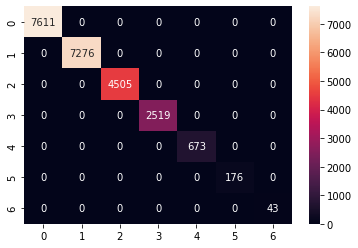

In [ ]:
matrizEntrenamiento = confusion_matrix(yTrain, predMLPTrain)
sb.heatmap(matrizEntrenamiento, annot=True, fmt='d')

<AxesSubplot:>

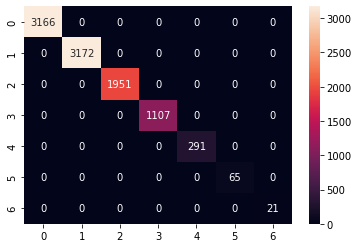

In [ ]:
matrizPrueba = confusion_matrix(yTest, predMLPTest)
sb.heatmap(matrizPrueba, annot=True, fmt='d')

## Balanceando la salida y reentrenando los modelos de  Regresión Logística, SVC y MLP

Los resultados están siendo sesgados por la cantidad de datos en cada clase de la variable de salida, al tener tantos de calificación A y tener tan pocos de calificación G, (una relación de 150:1) puede que con más datos de personas con calicación G el modelo se equivoque fácilmente.

Por esto, se hizo un remuestreo de los datos y se llevaron a 3000 cada una de las variables con menor cantidad de datos (E,F,G)

In [ ]:
# Balanceo de salida
data['loan_grade'].value_counts().sort_index()

A    10777
B    10448
C     6456
D     3626
E      964
F      241
G       64
Name: loan_grade, dtype: int64

In [ ]:
from sklearn.utils import resample

# Separate majority and minority classes
df_0 = dataPro[dataPro.loan_grade==0]
df_1 = dataPro[dataPro.loan_grade==1]
df_2 = dataPro[dataPro.loan_grade==2]
df_3 = dataPro[dataPro.loan_grade==3]
df_4 = dataPro[dataPro.loan_grade==4]
df_5 = dataPro[dataPro.loan_grade==5]
df_6 = dataPro[dataPro.loan_grade==6]
 
# Upsample minority class
df_4 = resample(df_4, replace=True, n_samples=3000, random_state=123) 
df_5 = resample(df_5, replace=True, n_samples=3000, random_state=123) 
df_6 = resample(df_6, replace=True, n_samples=3000, random_state=123) 
 
# Combine majority class with upsampled minority class
df_s = pd.concat([df_0,df_1,df_2,df_3,df_4,df_5,df_6])
 
# Display new class counts
df_s.loan_grade.value_counts()

0.0    10777
1.0    10448
2.0     6456
3.0     3626
4.0     3000
5.0     3000
6.0     3000
Name: loan_grade, dtype: int64

In [ ]:
X = df_s.drop('loan_grade', axis = 1)
y = df_s[['loan_grade']]

In [ ]:
XTrain, XTest, yTrain, yTest = train_test_split(X, y, train_size = 0.75, random_state = 456)

XTrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30230 entries, 15331 to 26707
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_income                   30230 non-null  float64
 1   person_emp_length               30230 non-null  float64
 2   loan_amnt                       30230 non-null  float64
 3   loan_int_rate                   30230 non-null  float64
 4   loan_status                     30230 non-null  float64
 5   loan_percent_income             30230 non-null  float64
 6   cb_person_cred_hist_length      30230 non-null  float64
 7   person_home_ownership_MORTGAGE  30230 non-null  float64
 8   person_home_ownership_OTHER     30230 non-null  float64
 9   person_home_ownership_OWN       30230 non-null  float64
 10  loan_intent_DEBTCONSOLIDATION   30230 non-null  float64
 11  loan_intent_EDUCATION           30230 non-null  float64
 12  loan_intent_HOMEIMPROVEMENT 

In [ ]:
modelLR2 = LogisticRegression()
modelLR2.fit(XTrain, yTrain)

LogisticRegression()

In [ ]:
print('beta_0: ', modelLR2.intercept_)
print('beta_1: ', list(zip(X.columns, modelLR2.coef_.flatten())))

beta_0:  [ 15.09420587   9.52555269   2.42305732  -1.81562682  -4.3771699
  -6.803434   -14.04658517]
beta_1:  [('person_income', 0.6951597287932104), ('person_emp_length', -1.376415398995975), ('loan_amnt', -1.6439589681954374), ('loan_int_rate', -41.108692281215596), ('loan_status', -2.1100224539818218), ('loan_percent_income', 1.0453556022114945), ('cb_person_cred_hist_length', -0.5768569337728285), ('person_home_ownership_MORTGAGE', 0.12220842019774919), ('person_home_ownership_OTHER', 0.7996820096971573), ('person_home_ownership_OWN', -0.10748804866194582), ('loan_intent_DEBTCONSOLIDATION', 1.0869121768168444), ('loan_intent_EDUCATION', 0.6733531451052305), ('loan_intent_HOMEIMPROVEMENT', 0.7795776386949596), ('loan_intent_MEDICAL', 1.1235827209033857), ('loan_intent_PERSONAL', 1.0789872310840074), ('loan_intent_VENTURE', 0.6307029154819322), ('cb_person_default_on_file_Y', -4.175983557543102)]


In [ ]:
trainPred = modelLR2.predict(XTrain)
trainAccuracyAllVarsLR = accuracy_score(yTrain, trainPred)
print(f'El desempeño en entrenamiento es {round(trainAccuracyAllVarsLR, 3)*100} %')

testPred = modelLR2.predict(XTest)
testAcurracy = accuracy_score(yTest, testPred)
print(f'El desempeño en prueba es {round(testAcurracy,3)*100} %')

El desempeño en entrenamiento es 74.5 %
El desempeño en prueba es 74.0 %


<AxesSubplot:>

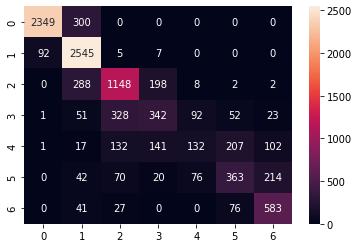

In [ ]:
matrizPrueba = confusion_matrix(yTest, testPred)
sb.heatmap(matrizPrueba, annot=True, fmt='d')

In [ ]:
modelSVC2 = SVC(kernel='poly', degree=5)
modelSVC2.fit(XTrain, yTrain)

trainPred = modelSVC2.predict(XTrain)
trainAccuracyImpVarsSVC2 = accuracy_score(yTrain, trainPred)
print(f'El desempeño en entrenamiento es {trainAccuracyImpVarsSVC2} %')

testPred = modelSVC2.predict(XTest)
testAcurracy = accuracy_score(yTest, testPred)
print(f'El desempeño en prueba es {testAcurracy} %')

KeyboardInterrupt: ignored

In [ ]:
matrizPrueba = confusion_matrix(yTest, testPred)
sb.heatmap(matrizPrueba, annot=True, fmt='d')

In [ ]:
#Red Neuronal
model2 = MLPClassifier(hidden_layer_sizes=(10,10,5),learning_rate_init = 0.001)
model2.fit(XTrain, yTrain)


#Evaluacion
predMLPTrain = model2.predict(XTrain)
predMLPTest = model2.predict(XTest)
accuracyMLPTrain = accuracy_score(yTrain, predMLPTrain)
accuracyMLPTest = accuracy_score(yTest, predMLPTest)
print(f'Train acurracy: {accuracyMLPTrain} %')
print(f'Test acurracy: {accuracyMLPTest} %')

In [ ]:
matrizPrueba = confusion_matrix(yTest, predMLPTest)
sb.heatmap(matrizPrueba, annot=True, fmt='d')

## E. Resultados

Basados en los resultados entregados por los modelos anteriores, se puede decir que antes del ressampling, los modelos SVC Y MLP son los mejores. Se llega a esta conclusión ya que ambos tienen un accuracy cercano o igual a 1 en train y test. Esto es sospechoso ya que existe un desbalance en los datos considerable, por lo que se opta por hacer resmpling aunque baje un poco la precisión.

Ahora bien, considerando los modelos con resampling el que mejor resultados obtuvo fue el SVC con un porcentaje de acierto del 80%, este modelo es mucho mejor ya que es más realista teniendo el cuenta el contexto del problema.